In [12]:
##Import all necessary import
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import imageio
import math
%matplotlib inline
imageio.plugins.ffmpeg.download()
# Imports for video streams
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [3]:
#This function is called once the image/frame is read from the directory/video respectively.
# In this function the input is an image(rgb format), it masks the region of interst and converts image into black n white, with
# white lines as bounderies of interest(road lines)
def mask_region(image):
    color_select = np.copy(image)
    line_image = np.copy(image)*0
    #line_image=np.copy(image)

    ysize = image.shape[0]
    xsize = image.shape[1]


    red_threshold = 175
    green_threshold = 100
    blue_threshold = 40
    
    rgb_threshold = [red_threshold, green_threshold, blue_threshold]
    thresholds = (image[:,:,0] < rgb_threshold[0]) \
                | (image[:,:,1] < rgb_threshold[1]) \
                | (image[:,:,2] < rgb_threshold[2])
        
    color_select[thresholds] = [0,0,0]

    left_bottom=[30,539]
    right_bottom=[950,539]
    left_top=[440,320]
    right_top=[530,320]



    fit_left=np.polyfit((left_bottom[0],left_top[0]),([left_bottom[1],left_top[1]]),1)
    fit_right=np.polyfit((right_bottom[0],right_top[0]),(right_bottom[1],right_top[1]),1)
    fit_bottom=np.polyfit((left_bottom[0],right_bottom[0]),(left_bottom[1],right_bottom[1]),1)
    fit_top=np.polyfit((left_top[0],right_top[0]),(left_top[1],right_top[1]),1)


    XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
    region_thresholds=(YY>(XX*fit_left[0]+fit_left[1])) & \
                    (YY > (XX*fit_right[0]+fit_right[1])) &\
                    (YY<(XX*fit_bottom[0]+fit_bottom[1])) &\
                    (YY> (XX*fit_top[0]+fit_top[1]))

    line_image[~thresholds & region_thresholds]=[255,255,255]

    return line_image

# this function takes image(black n white) as input and converts it into 2-channel grayscale image 
def grayscale(img):
    #plt.imshow(gray, cmap='gray')
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# this function is for edge detection  
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

# this funtion is called before canny function 
def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

# this function give the region of interest 

def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

# for extra-polating the lines
def draw_line(blank_img,hough_lines,roi_points,color=[255, 0, 0], thickness=20):
    left_points=[]
    right_points=[]
    for line in hough_lines:
        for x1,y1,x2,y2 in line:
            m=(y2-y1)/(x2-x1)
            if np.isnan(float(m)):
                continue
            if abs(m) < 0.3:
                continue
            if m>0:
                right_points.append((x1,y1))
                right_points.append((x2,y2))
            elif m<0:
                left_points.append((x1,y1))
                left_points.append((x2,y2))
    if len(left_points) > 1:
        left_points=np.array(left_points)
        X=left_points[:,0]
        #take last point for good contrast
        Y=left_points[:,-1]
        m,c=np.polyfit(X,Y,1)
        bottom_y=int(roi_points[0,1])-1
        bottom_x = round(int((bottom_y - c) / m)) - 1
        
        top_y=int(roi_points[1,1])+1
        top_x = round(int((top_y - c) / m)) + 1
        cv2.line(blank_img, (bottom_x,bottom_y), (top_x,top_y), color, thickness)
        
    if len(right_points) > 1:
        right_points=np.array(right_points)
        X=right_points[:,0]
        #take last point for good contrast
        Y=right_points[:,-1]
        m,c=np.polyfit(X,Y,1)
        bottom_y=int(roi_points[3,1])-1
        bottom_x = round(int((bottom_y - c) / m)) - 1
        top_y=int(roi_points[2,1])+1
        top_x = round(int((top_y - c) / m)) + 1
        
        cv2.line(blank_img, (bottom_x,bottom_y), (top_x,top_y), color, thickness)
        
    return blank_img


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    #line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    return lines



def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

In [4]:
# this is the actual pipeline. All function are called in order with each function providing the input to next function
def process_image(initial_img):
    image=np.copy(initial_img)
    mask_img=mask_region(image)
    gray_img=grayscale(mask_img)
    blur_gray=gaussian_blur(gray_img, 7)
    edges=canny(blur_gray, 50, 150)
    imshape = image.shape
    roi_img=region_of_interest(edges, np.array([[(0,imshape[0]),(0, 0), (imshape[1], 0), (imshape[1],imshape[0])]], dtype=np.int32))
    lines=hough_lines(roi_img, 1, np.pi/180, 30, 10, 150)
    roi_vertices = np.array([[100,image.shape[0]], [440,320],[530,320],[920,image.shape[0]]], dtype=np.int32)
    blank_img=np.zeros((mask_img.shape[0], mask_img.shape[1], 3), dtype=np.uint8) # creating a blank to draw lines on
    hough_img= draw_line(blank_img,lines,roi_vertices)
    final_img=weighted_img(hough_img, initial_img, α=0.8, β=1., γ=0.)
    return final_img

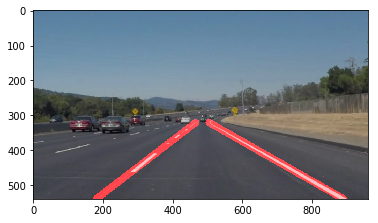

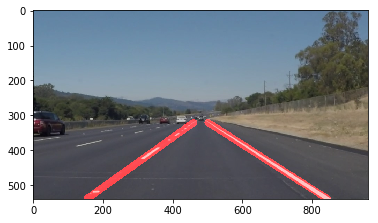

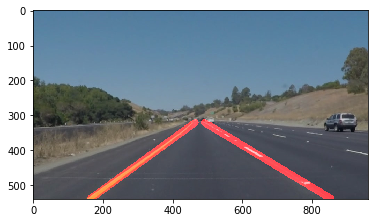

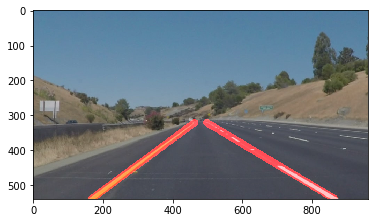

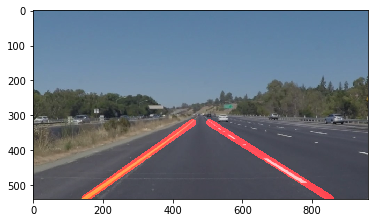

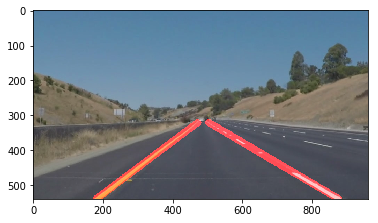

In [5]:
# here the images are read form the directory and each image is processed and saved to drectory.

i=0;
for file in os.listdir("D:\\Udacity-Nano\\Project\\test_images\\"):
    initial_img=mpimg.imread("D:\\Udacity-Nano\\Project\\test_images\\"+file)
    output_img=process_image(initial_img)
    plt.figure()
    plt.imshow(output_img)
    mpimg.imsave("test_image_"+str(i),output_img,format='jpg')
    i+=1

In [8]:
white_output = 'D:\\Udacity-Nano\\Project\\test_videos_output\\challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("D:\\Udacity-Nano\\Project\\test_videos\\challenge.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video D:\Udacity-Nano\Project\test_videos_output\challenge.mp4
[MoviePy] Writing video D:\Udacity-Nano\Project\test_videos_output\challenge.mp4


100%|██████████████████████████████| 251/251 [00:39<00:00,  7.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: D:\Udacity-Nano\Project\test_videos_output\challenge.mp4 

Wall time: 42.4 s
